# Imports

In [38]:
import tensorflow.python.platform

In [2]:
##########
# basics #
##########

import warnings
warnings.filterwarnings('ignore')
import collections
import datetime
import glob
import hashlib
import itertools
import math
import operator
import os
import pickle
import random
import re
import string
import sys
import time

###########
# science #
###########

import scipy as sp
import numpy as np
import pandas as pd
rseed = random.seed(42)

######
# ml #
######

import xgboost as xgb
import theano as thno
import keras as krs
import tensorflow as tf

###################
# sklearn tooling #
###################

from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn import grid_search
from sklearn import pipeline
from sklearn import feature_selection

#################
# visualization #
#################

# plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
import cufflinks as cf
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'), api_key=os.environ.get('PLOTLY_APIKEY'))
cf.set_config_file(offline=False, world_readable=True, theme='pearl')

# matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
mpl.rcParams['figure.figsize']=(12.0,4.0)
%matplotlib inline

# seaborn
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted', n_colors=15, desat=None)
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

############
# sys info #
############

%reload_ext watermark
%watermark -a "Ken Cavagnolo" -n -u -v -m -h -g -p numpy,scipy,pandas,xgboost,sklearn,theano,matplotlib,seaborn,plotly

Ken Cavagnolo 
last updated: Thu Oct 06 2016 

CPython 2.7.10
IPython 4.1.1

numpy 1.11.2
scipy 0.18.1
pandas 0.19.0
xgboost 0.6a2
sklearn 0.0
theano 0.8.2
matplotlib 1.5.3
seaborn 0.8.dev0
plotly 1.12.9

compiler   : GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.0.72)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
host name  : DrGonzo.local
Git hash   : 45278108f405c82f1e23d4efdb4747847ae39131


# Basic Operations

In [3]:
sess = tf.Session()

In [4]:
hello = tf.constant('Hello, World!')

In [5]:
print sess.run(hello)

Hello, World!


In [6]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)

In [7]:
add = tf.add(a, b)
mul = tf.mul(a, b)

In [8]:
feed = {a: 2,
        b: 3}
print sess.run(add, feed_dict=feed)
print sess.run(mul, feed_dict=feed)

5.0
6.0


In [9]:
a = [[2.],[0.5]]
b = [[2.]]
print a
print
print b

[[2.0], [0.5]]

[[2.0]]


In [10]:
print sess.run(tf.matmul(a, b))
print sess.run(tf.div(a, b))

[[ 4.]
 [ 1.]]
[[ 1.  ]
 [ 0.25]]


In [11]:
sess.close()

# Simple Linear Regression

## Sim Data

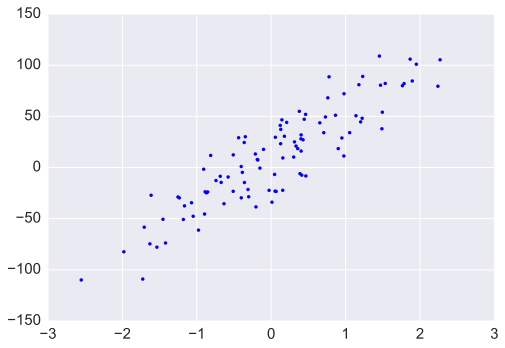

In [12]:
# fake data
from sklearn.datasets import make_regression
n = 100
m = round(0.*n)
rng = np.random.RandomState(0)
X_train, y_train = make_regression(n_samples=n, n_features=1,
                                   random_state=0, noise=20.0,
                                   bias=10.0)

# strong outliers
X_outliers = rng.normal(X_train.min(), X_train.max(), size=(m, 1))
y_outliers = rng.normal(y_train.min(), y_train.max(), size=m)
X_outliers[:m/2, :] += X_train.max() + X_train.mean() / 4.
X_outliers[m/2:, :] += X_train.min() - X_train.mean() / 4.
y_outliers[:m/2] += y_train.min() - y_train.mean() / 4.
y_outliers[m/2:] += y_train.max() + y_train.mean() / 4.

# concat
X_train = np.vstack((X_train, X_outliers))
X_train = X_train.flatten().astype(np.float32)
y_train = np.concatenate((y_train, y_outliers))
y_train = y_train.flatten().astype(np.float32)

# testing
#X_train = np.random.rand(100).astype(np.float32)
#y_train = X_train * 0.1 + 0.3

# plot
plt.plot(X_train, y_train, 'b.')

## Model

In [13]:
# model components
W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
b = tf.Variable(tf.zeros([1]))
y = W * X_train + b

## Learn

In [14]:
# cost func to opt
cost = tf.reduce_mean(tf.square(y - y_train))

In [15]:
# set learning rate and GD step size
lrate = 0.03
optimizer = tf.train.GradientDescentOptimizer(lrate)
train_step = optimizer.minimize(cost)

In [16]:
# start tf sessions
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [17]:
# train
steps = 10000
for step in range(steps):
    sess.run(train_step)
    if step % 1000 == 0:
        print(step, sess.run(W)[0], sess.run(b)[0], sess.run(cost))

(0, 2.5423918, 0.65649223, 2209.9148)
(1000, 42.853325, 8.371645, 456.68594)
(2000, 42.853325, 8.371645, 456.68594)
(3000, 42.853325, 8.371645, 456.68594)
(4000, 42.853325, 8.371645, 456.68594)
(5000, 42.853325, 8.371645, 456.68594)
(6000, 42.853325, 8.371645, 456.68594)
(7000, 42.853325, 8.371645, 456.68594)
(8000, 42.853325, 8.371645, 456.68594)
(9000, 42.853325, 8.371645, 456.68594)


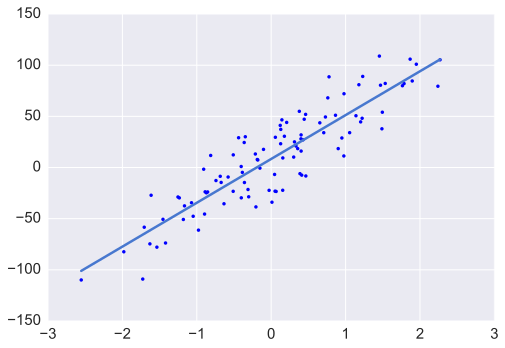

In [18]:
plt.plot(X_train, y_train, 'b.')
xd = np.linspace(X_train.min(), X_train.max(), 50)
yd = xd * sess.run(W)[0] + sess.run(b)[0]
plt.plot(xd, yd)

# Simple Classification

## Sim Data

In [36]:
from sklearn.datasets import make_moons, make_circles, make_classification
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=rseed),
            make_circles(noise=0.2, factor=0.5, random_state=rseed),
            linearly_separable]

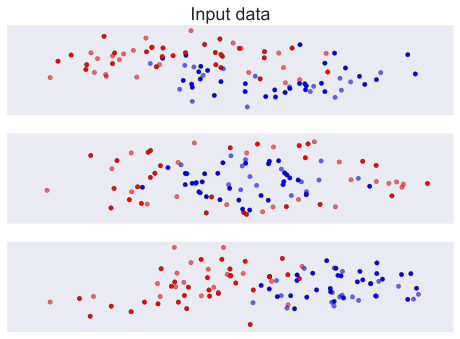

In [37]:
figure = plt.figure()
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = preprocessing.StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        model_selection.train_test_split(X, y, test_size=.4, random_state=42)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                         np.arange(y_min, y_max, 0.2))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = mpl.colors.ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")

    # Plot points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

# Scratch